In [19]:
import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from matplotlib.colors import ListedColormap
from scipy.special import softmax

sns.set_theme(context='notebook', style='white')

%matplotlib inline

In [2]:
model_prefix = "model/model.ckpt-76152679"
depth = 8
features = 32
num_classes = 4

img_shape = (150, 300, 300, 1)  # Single greyscale channel
dtype = np.float32

def preprocess(pixels, norm=False):
    pixels = np.transpose(pixels, axes=(2,1,0,3))
    if norm:
        return (pixels - 128.) / 33.
    return pixels

In [3]:
conv3d = tf.contrib.layers.conv3d
relu = tf.nn.relu
conv = functools.partial(conv3d,
                         num_outputs=features,
                         kernel_size=(3, 3, 3),
                         padding='VALID')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
num_boxes = 1

full_shape = (num_boxes,) + img_shape
data = np.ndarray(full_shape, dtype=dtype)
seg = np.ndarray(full_shape, dtype=np.uint8)

for box_idx in range(data.shape[0]):
    fname = f"data/box_{box_idx:02}.npz"
    infile = np.load(fname)
    data[box_idx] = preprocess(infile["img"], norm=True)
    seg[box_idx] = preprocess(infile["seg"])

In [5]:
sess = tf.Session()

patches = tf.placeholder(dtype, (None,) + img_shape)

net = conv(patches, scope='conv0_a')
net = conv(net, scope='conv0_b', activation_fn=None)

for i in range(1, depth):
    with tf.name_scope('residual%d' % i):
        in_net = net
        net = relu(net)
        net = conv(net, scope='conv%d_a' % i)
        net = conv(net, scope='conv%d_b' % i, activation_fn=None)
        net += in_net[:, 2:-2, 2:-2, 2:-2, :]

net = relu(net)
logits = conv3d(net, 
                num_classes, 
                (1, 1, 1), 
                activation_fn=None,
                scope='conv_point')

saver = tf.train.Saver()
#saver = tf.train.import_meta_graph(f"{model_prefix}.meta", clear_devices=True)
saver.restore(sess, model_prefix)

Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from model/model.ckpt-76152679


In [6]:
# from tensorflow.python import pywrap_tensorflow
# reader = pywrap_tensorflow.NewCheckpointReader(model_prefix)
# var_to_shape_map = reader.get_variable_to_shape_map()
# tensors = []
# for key in sorted(var_to_shape_map):
#     print("tensor_name: ", key)
#     if key.endswith("weights"):
#         tensors.append(reader.get_tensor(key))

In [7]:
#for i in range(16):
#    s0 = np.sum(tensors[i][:,:,:,0,0], axis=(1,2))
#    s1 = np.sum(tensors[i][:,:,:,0,0], axis=(2,0))
#    s2 = np.sum(tensors[i][:,:,:,0,0], axis=(0,1))
#    print(s0,s1,s2)

In [8]:
#from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
#print_tensors_in_checkpoint_file(file_name=model_prefix, tensor_name='', all_tensors=False)

In [9]:
%%time
result = sess.run(logits, {patches: data})

CPU times: user 7min 15s, sys: 47.8 s, total: 8min 3s
Wall time: 2min 5s


In [10]:
predict = np.argmax(result, axis=4)
predict = np.pad(predict, ((0,), (16,), (16,), (16,)))

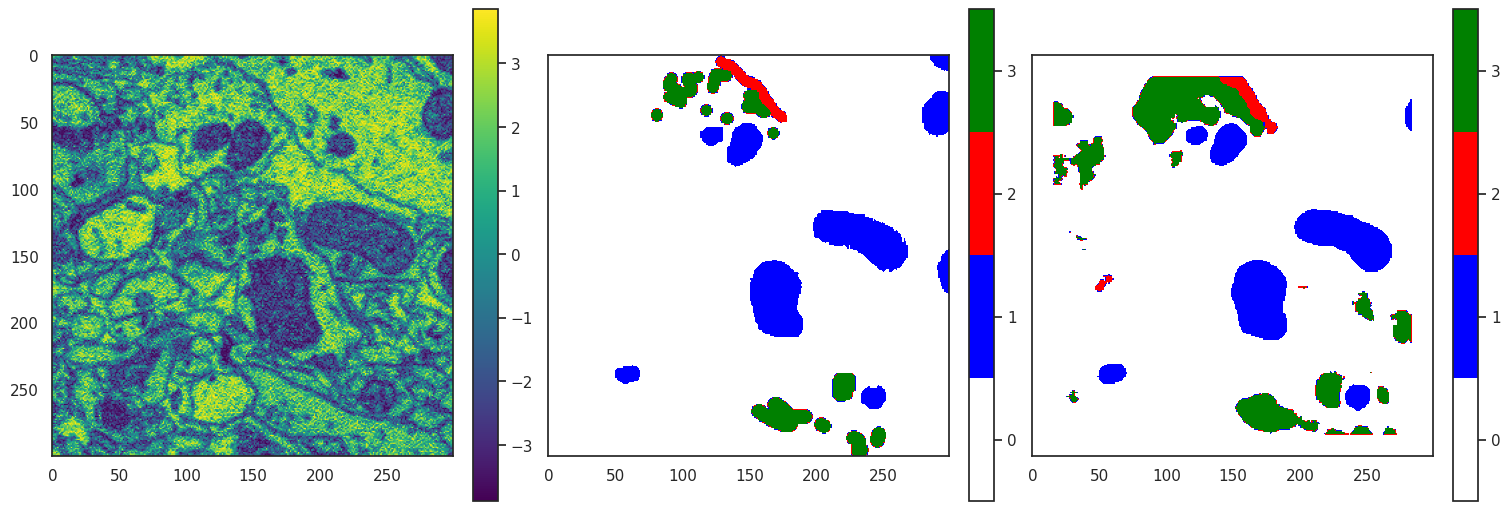

In [11]:
my_cmap = ListedColormap(["white", "blue", "red", "green"])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5),
                         sharex=True, sharey=True,
                         squeeze=False, constrained_layout=True)

zslice = 75
img = axes[0][0].imshow(data[0, zslice], cmap="viridis")
fig.colorbar(img, ax=axes[0][0])
img = axes[0][1].imshow(seg[0, zslice], cmap=my_cmap, vmin=-0.5, vmax=3.5)
fig.colorbar(img, ax=axes[0][1], ticks=range(4))
img = axes[0][2].imshow(predict[0, zslice], cmap=my_cmap, vmin=-0.5, vmax=3.5)
fig.colorbar(img, ax=axes[0][2], ticks=range(4))

In [21]:
s = softmax(result[0], axis=3)

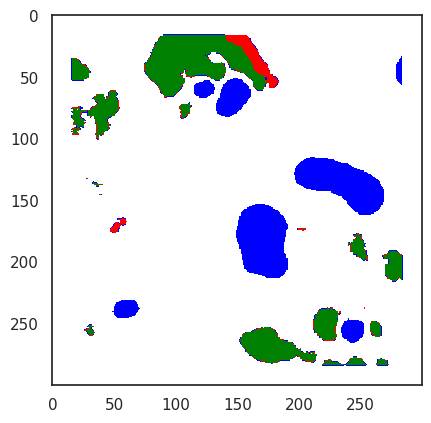

In [24]:
s.shape

(118, 268, 268, 4)

In [25]:
sm = np.max(s, axis=3)

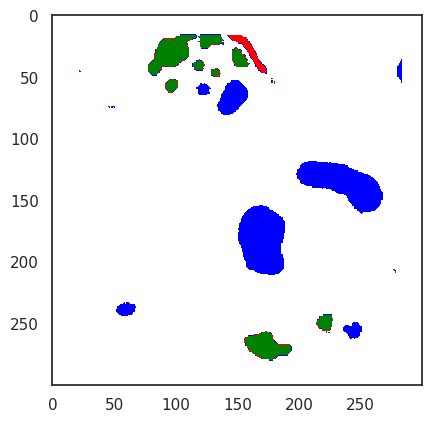

In [44]:
sa = np.argmax(s, axis=3)
bad = sm < 0.9
sa[bad] = 0
sa = np.pad(sa, 16)

#fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
#axes[0].imshow(seg[0, 75], cmap=my_cmap, vmin=-0.5, vmax=3.5)
#axes[1].imshow(predict[0, 75], cmap=my_cmap, vmin=-0.5, vmax=3.5)
#axes[2].imshow(sa[75], cmap=my_cmap, vmin=-0.5, vmax=3.5)
plt.imshow(sa[75], cmap=my_cmap, vmin=-0.5, vmax=3.5)